# Réseau fully connected

## Architecture

Dans les cours précédents (cours 2), nous avons construits des réseau de neurons fully connected pour des problèmes de classification. Ici, nous avons à faire à un problème de prédiction et nos données sont discrètes.  

### Inspiration

Le réseau construit dans ce notebook est basé sur l'article ["A Neural Probabilistic Language Model"](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).  
Voici à quoi ressemble l'architecture de ce réseau :   
<img src="images/bengio.png" alt="bengio" width="400"/>  
Figure extraite de l'article original.

L'article original est utilisé en prenant des mots en entrée et en prédisant un mot. Dans notre cas, nous allons utiliser les caractères comme dans le notebook précédent.  
**Matrice d'embedding $C$** : Ce qu'on remarque à première vue dans le réseau c'est la présence d'une matrice $C$ qui va encoder le mot (ou le caractère dans un espace latent). C'est une pratique presque systématiquement utilisé en NLP car cela permet de rapprocher les mots "similaires" dans l'espace latent.  
Par exemple, dans la plupart des phrases on pourrait interchanger les mots "chien" et "chat", ce qui signifie que ces mots vont avoir une representation proche dans l'espace latent tandis que les mots "chien" et "est" ne vont pas avoir une representation proche.   
**Reste du réseau** : Le reste du réseau est plus classique, il prend en entrée la concatenation des embeddings de chaque mot (ou caractère) et prédit un mot (ou caractère en sortie).

Le modèle de l'article est entraîné par minimisation du negative log likelihood (comme ce que nous avons fait dans le notebook précédent avec le modèle bigramme).

### Notre approche

Dans l'article, ils utilisent 3 mots pour prédire le 4ème mot. Nous allons nous baser sur le même principe et prédire le 4ème caractère à partir des 3 caractères précédents.  
La dimension de l'espace latent utilisé dans l'article est 30 pour un dictionnaire contenant 17 000 mots distincts. Comme nous avons 46 caracactères, prenons une dimension d'embedding de 10 assez arbitrairement.

## Implémentation 

Commençons par reconstruire nos listes stoi et itos du notebook précédent : 

In [9]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
%matplotlib inline

In [3]:
words = open('prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

### Dataset et dataloader

Construisons notre dataset qui va être un peu différent car les entrées seront au nombre de 3 au lieu de une. 

In [6]:
block_size = 3 # La longueur du contexte, combien de caractères pour prédire le suivant ?
X, Y = [], []
for k,w in enumerate(words):
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    if (k<2): ## On affiche ce à quoi ressemble le dataset pour les deux premiers mots
        print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

... ---> M
..M ---> A
.MA ---> R
MAR ---> I
ARI ---> E
RIE ---> .
... ---> J
..J ---> E
.JE ---> A
JEA ---> N
EAN ---> .


In [8]:
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([226325, 3]) torch.int64 torch.Size([226325]) torch.int64


/tmp/ipykernel_261819/4009735651.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/tmp/ipykernel_261819/4009735651.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y)


On va maintenant utiliser pytorch pour construire nos dataset de training, validation et test.

In [12]:
dataset=TensorDataset(X, Y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(TensorDataset(X, Y),[train_size, val_size, test_size])
print("Taille du dataset de training : ",len(train_dataset))
print("Taille du dataset de validation : ",len(val_dataset))
print("Taille du dataset de test : ",len(test_dataset))

Taille du dataset de training :  181060
Taille du dataset de validation :  22632
Taille du dataset de test :  22633


Et on va créer nos dataloaders pour l'optimisation par mini-batch.

In [25]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Couches du réseau 

Pour comprendre en profondeur le réseau que l'on construit ici, nous n'utiliserons pas les fonctions nn.Linear() de pytorch pour la construction des couches.   
On va commencer par définir le nombre de neurones des différentes couches.

In [27]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

Construisons notre matrice $C$ d'embedding (qui a des paramètres apprenables).

In [94]:
C = torch.randn((46, embed_dim))
C[X].shape

torch.Size([226325, 3, 10])

En appelant C[X], grâce au formidable [indexing de pytorch](http://blog.ezyang.com/2019/05/pytorch-internals/). On obtient les valeurs d'embedding de chacun des 3 caractères de nos 226325 exemples.

On peut maintenant créer nos couches cachées $W_1$ et $W_2$ ainsi que leurs biais $b_1$ et $b_2$.

In [95]:
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
print("Nombre de paramètres du modèle : ",sum(p.nelement() for p in parameters))

Nombre de paramètres du modèle :  15906


Pour pouvoir entraîner ces couches, il faut activer le paramètre requires_grad de pytorch.

In [96]:
for p in parameters:
  p.requires_grad = True

### Comment trouver le bon learning rate ?

Le choix du learning rate est très important lors de l'entraînement d'un réseau de neurones et c'est souvent difficile de savoir quelle valeur choisir avant d'avoir fait des tests.   
Une bonne façon de choisir le learning rate est la suivante :   
On construit une liste de 1000 valeurs entre -3 et 0 puis on prend $10^{valeur}$ pour chaque valeur
Cela va nous donner une liste de valeurs entre $10^{-3} = 0.001$ et $10^{0}=1$ qui sont un panel de valeurs potentielles pour notre learning rate.

In [68]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

On va ensuite tracker les valeurs de loss en fonction du learning rate sur l'ensemble de nos valeurs sur l'entraînement.

In [71]:
lri = []
lossi = []
count=0
while count<999:
    for x,y in train_loader:
        count+=1
        if count==999:
            break
        # forward pass
        emb = C[x]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2 
        loss = F.cross_entropy(logits, y)
        
        # retropropagation
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # Mise à jour des poids du modèle
        lr = lrs[count]
        for p in parameters:
            p.data += -lr * p.grad

        lri.append(lre[count])
        lossi.append(loss.log10().item())

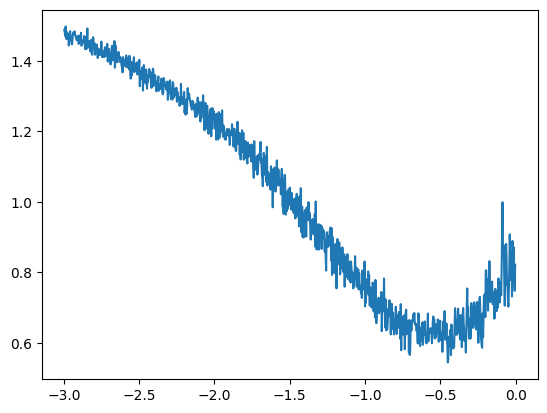

In [72]:
plt.plot(lri, lossi)


Avec cette courbe, on peut déduire qu'une bonne valeur de learning rate se situe aux alentours de $10^{-1}$ et $10^{-0.5}$.  
On va donc choisir un learning rate de 0.2 que l'on diminuera au cours de l'entraînement (pratique courante pour une convergence rapide et un optimisation précise sur la fin de l'entraînement).

### Point sur la tangente hyperbolique

Dans notre optimisation, nous avons utilisé la fonction tangente hyperbolique comme fonction d'activation. Il s'agit d'une fonction d'activation qui est assez souvent utilisé à la place de ReLU ou de sigmoïde.   
Elle est définie de la manière suivante :   
$\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^x - e^{-x}}{e^x + e^{-x}}$  
Et on peut la visualiser en python : 

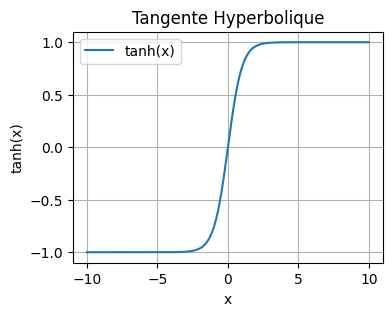

In [75]:
import numpy as np
x = np.linspace(-10, 10, 400)

y = np.tanh(x)

plt.figure(figsize=(4, 3))
plt.plot(x, y, label='tanh(x)')
plt.title('Tangente Hyperbolique')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.legend()
plt.show()

### Optimisation du réseau 

Passons maintenant à l'optimisation de notre réseau. Définissons nos hyperparamètres : 

In [82]:
lr=0.2
epochs=20

In [97]:
stepi = []
for epoch in range(epochs):
    loss_epoch=0
    for x,y in train_loader:
      
        # forward pass
        emb = C[x]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2 
        loss = F.cross_entropy(logits, y)
        
        # retropropagation
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # Mise à jour des poids du modèle
        lr=lr if epoch<50 else lr*0.1
        for p in parameters:
            p.data += -lr * p.grad
        loss_epoch+=loss
    loss_epoch=loss_epoch/len(train_loader)
    stepi.append(epoch)
    lossi.append(loss_epoch.detach().item())
    

In [93]:
plt.plot(stepi, lossi)

AttributeError: 'list' object has no attribute 'numpy'